## Importing desired modules

In [2]:
#pandas specific modules
import pandas as pd
#numpy specefic
import numpy as np
#for visualization
import seaborn as sns
import matplotlib.pyplot as plt
# for Q-Q plots
import scipy.stats as stats
# to split the datasets
from sklearn.model_selection import train_test_split
# the scaler - for robust scaling
from sklearn.preprocessing import RobustScaler
# for one hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder
#to remove quasi constant features 
from sklearn.feature_selection import VarianceThreshold
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


## Goal of this Notebook (We are here simulating a typical Research Phase)

- Explore data
- Explore features 
- Exploratory Data Analysis 
- Explore which prediction technique is the best 
- Gauging mean absolute deviation 
- Selecting the best model for the analysis which we will use in further steps

#### BUSINESS PROBLEM 

- Predication of bike rental count hourly  based on the environmental and seasonal settings.

#### HELPER FUNCTIONS

In [15]:
def diagnostic_plots(df, variable):
    '''
    it plots the histogram, QQ plot and boxplt to check the distributions of the feats
    '''
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

def find_skewed_boundaries(df, variable, distance):
    
    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

def random_slice_data(dataframe, fraction, other_info=None):
    """Returns fraction of data"""
    return dataframe.sample(frac=fraction)

#### DATASET HOURLY BIKE SHARING DATASET

In [23]:
df = pd.read_csv('/Users/ravishaggarwal/Desktop/cs_itw/by/Bike-Sharing-Dataset/hour_.csv')

In [16]:

#keeping a random 10% data for score test
df_frac = random_slice_data(df, 0.1)

In [22]:
df_frac.shape

(1738, 18)

In [21]:
#df_frac.to_csv('/Users/ravishaggarwal/Desktop/cs_itw/by/Bike-Sharing-Dataset/hour_fraction.csv',index=False)

In [ ]:
df.info()

- data set has 16 features and 17379 records with no null values 

In [176]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [177]:
#df = df.set_index('dteday')

In [178]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### DATA DESCRIPTION

	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users

In [179]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


#### FEATURE EXPLORATION

#### FEATRURE INSTANT 

- instant: record index

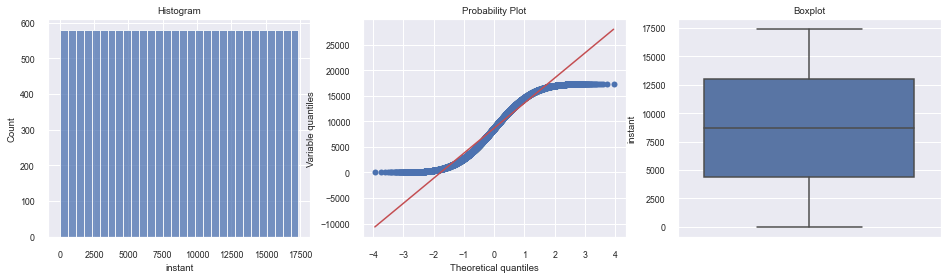

In [180]:
diagnostic_plots(df, 'instant')

- instant column is just count and doesn not add any value we shall remove this feature 

In [181]:
df = df.drop('instant',axis = 1)

In [182]:
df.columns

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

#### FEATURE SEASON

- season : season (1:springer, 2:summer, 3:fall, 4:winter)

In [183]:
df.season.describe()

count    17379.000000
mean         2.501640
std          1.106918
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: season, dtype: float64

In [184]:
df_season = df.groupby('season').sum()['cnt']

In [185]:
df_season.head()

season
1     471348
2     918589
3    1061129
4     841613
Name: cnt, dtype: int64

<AxesSubplot:xlabel='season'>

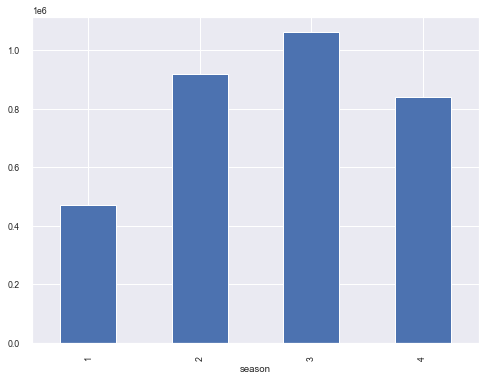

In [186]:
fig, ax = plt.subplots(figsize=(8,6))
df_season.plot(kind='bar', ax=ax)

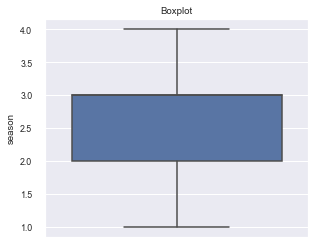

In [187]:
 # boxplot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 3)
sns.boxplot(y=df['season'])
plt.title('Boxplot')
plt.show()

- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- The maximum bike shares are in the fall and summer season followed by winter
-  Springer has the least bike sharing counts amonth the seasons 

In [188]:
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### FEATURE yr (YEAR) 
- yr : year (0: 2011, 1:2012) 

In [189]:
df_year = df.groupby('yr').sum()['cnt']

<AxesSubplot:xlabel='yr'>

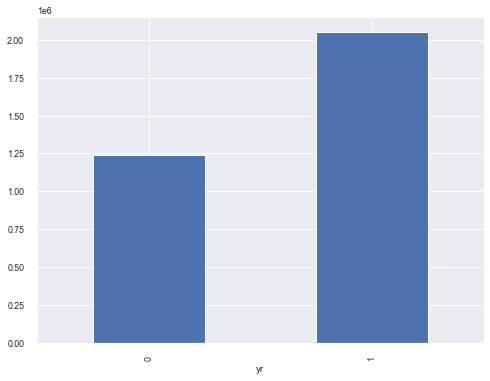

In [190]:

fig, ax = plt.subplots(figsize=(8,6))
df_year.plot(kind='bar', ax=ax)

- in the year 2012 we see a greater rise in the bike sharing 

#### FEATURE MONTH
- mnth : month ( 1 to 12)

[Text(0, 0, '0'), Text(1, 0, '1')]

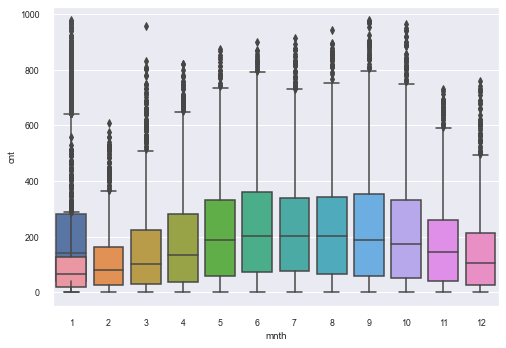

In [191]:
sns.set(font_scale=0.8)
fig.set_size_inches(15, 15)
sns.boxplot(data=df,y="cnt",orient="v")
sns.boxplot(data=df,y="cnt",x="mnth",orient="v")

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)



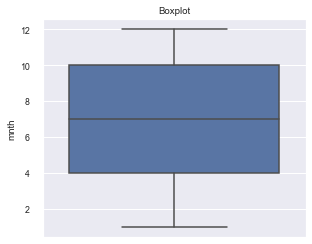

In [192]:
 # boxplot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 3)
sns.boxplot(y=df['mnth'])
plt.title('Boxplot')
plt.show()

- Winter months like January, February, March experienced less bike sharing 
- as compare to the summer months April, May, June, July, August, September
- Then the trend again goes down in fall and winters approaching - October, November, December 

#### FEATURE hr (HOUR)
- hr : hour (0 to 23)

[Text(0, 0, '0'), Text(1, 0, '1')]

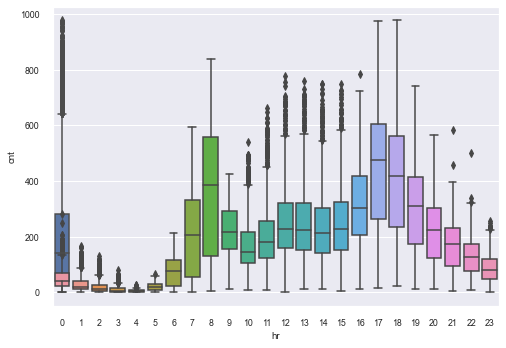

In [193]:
sns.set(font_scale=0.8)
fig.set_size_inches(15, 15)
sns.boxplot(data=df,y="cnt",orient="v")
sns.boxplot(data=df,y="cnt",x="hr",orient="v")

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

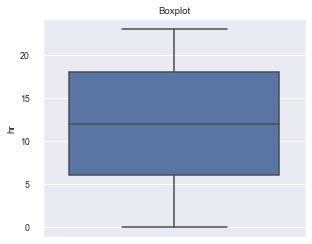

In [194]:
 # boxplot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 3)
sns.boxplot(y=df['hr'])
plt.title('Boxplot')
plt.show()

- Plot shows that ride share is high from 7 to 9 am then from 4 to 8pm which makes sense as 7 to 9am and 4 to 8pm are rush hours where people commute alot

#### FEATURE HOLIDAY
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)

In [195]:
df.holiday.unique()

array([0, 1])

<AxesSubplot:xlabel='holiday'>

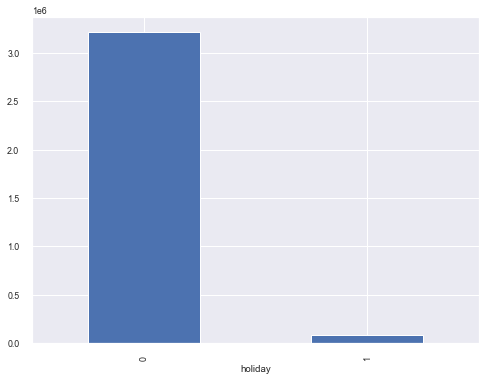

In [196]:
df_holiday = df.groupby('holiday').sum()['cnt']
fig, ax = plt.subplots(figsize=(8,6))
df_holiday.plot(kind='bar', ax=ax)

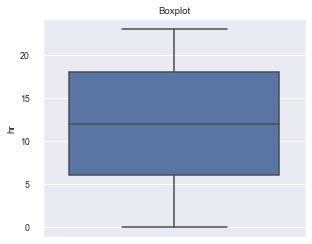

In [197]:
 # boxplot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 3)
sns.boxplot(y=df['hr'])
plt.title('Boxplot')
plt.show()

- during the holidays the demand of the bike sharing is very low as compare to non holiday days

#### FEATURE WEEKDAY
- weekday : day of the week

<AxesSubplot:xlabel='weekday'>

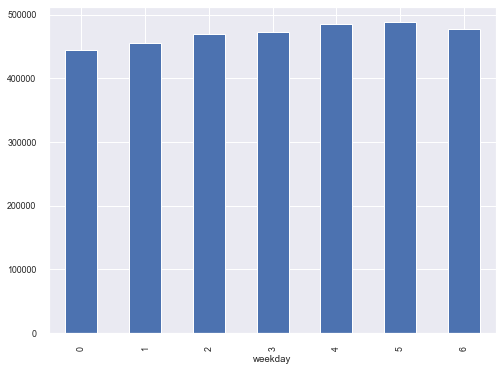

In [198]:
df_week = df.groupby('weekday').sum()['cnt']
fig, ax = plt.subplots(figsize=(8,6))
df_week.plot(kind='bar', ax=ax)

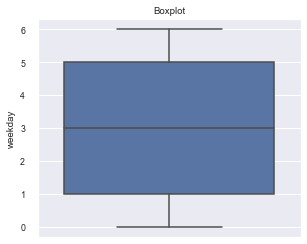

In [199]:
 # boxplot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 3)
sns.boxplot(y=df['weekday'])
plt.title('Boxplot')
plt.show()

- On Weekends the demand is less as compare to the rest of the days
- removing it 

In [200]:
df = df.drop('weekday',axis = 1)

#### FEATURE WORKINGDAY

- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.

<AxesSubplot:xlabel='workingday'>

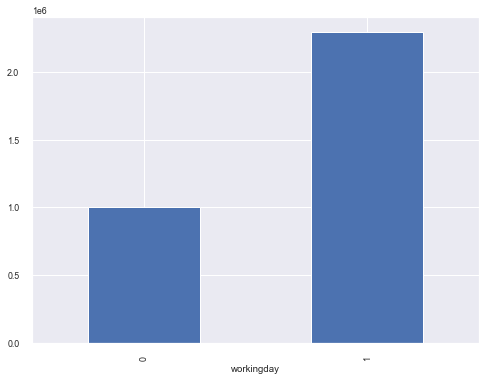

In [201]:
df_wd = df.groupby('workingday').sum()['cnt']
fig, ax = plt.subplots(figsize=(8,6))
df_wd.plot(kind='bar', ax=ax)

- During workdays the rentals are more as compare to when it is holiday or weekend

#### FEATURE WEATHERSIT

 - weathersit
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

[Text(0, 0, '0'), Text(1, 0, '1')]

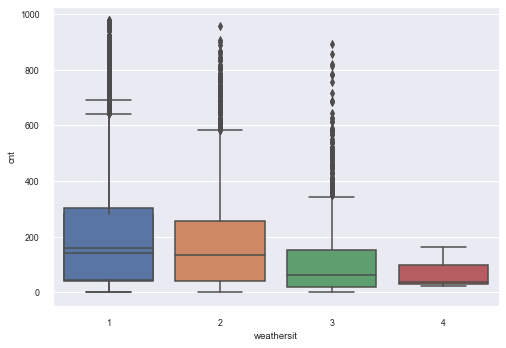

In [202]:
sns.set(font_scale=0.8)
fig.set_size_inches(15, 15)
sns.boxplot(data=df,y="cnt",orient="v")
sns.boxplot(data=df,y="cnt",x="weathersit",orient="v")

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

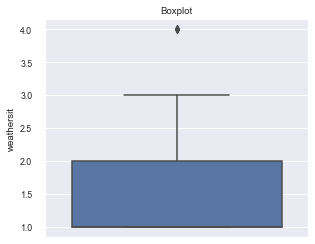

In [203]:
 # boxplot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 3)
sns.boxplot(y=df['weathersit'])
plt.title('Boxplot')
plt.show()

- the bike rentals are maximum when the weather is clear otherwise it keeps on falling when the weather is misty or rainy or snowy

#### FEATURE TEMP
- - temp : Normalized temperature in Celsius. The values are divided to 41 (max)

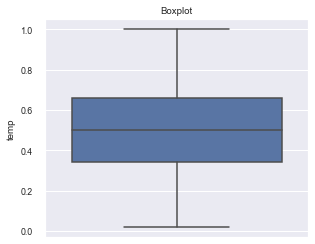

In [204]:
 # boxplot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 3)
sns.boxplot(y=df['temp'])
plt.title('Boxplot')
plt.show()

[Text(0, 0, '0.02'),
 Text(1, 0, '0.04'),
 Text(2, 0, '0.06'),
 Text(3, 0, '0.08'),
 Text(4, 0, '0.1'),
 Text(5, 0, '0.12'),
 Text(6, 0, '0.14'),
 Text(7, 0, '0.16'),
 Text(8, 0, '0.18'),
 Text(9, 0, '0.2'),
 Text(10, 0, '0.22'),
 Text(11, 0, '0.24'),
 Text(12, 0, '0.26'),
 Text(13, 0, '0.28'),
 Text(14, 0, '0.3'),
 Text(15, 0, '0.32'),
 Text(16, 0, '0.34'),
 Text(17, 0, '0.36'),
 Text(18, 0, '0.38'),
 Text(19, 0, '0.4'),
 Text(20, 0, '0.42'),
 Text(21, 0, '0.44'),
 Text(22, 0, '0.46'),
 Text(23, 0, '0.48'),
 Text(24, 0, '0.5'),
 Text(25, 0, '0.52'),
 Text(26, 0, '0.54'),
 Text(27, 0, '0.56'),
 Text(28, 0, '0.58'),
 Text(29, 0, '0.6'),
 Text(30, 0, '0.62'),
 Text(31, 0, '0.64'),
 Text(32, 0, '0.66'),
 Text(33, 0, '0.68'),
 Text(34, 0, '0.7'),
 Text(35, 0, '0.72'),
 Text(36, 0, '0.74'),
 Text(37, 0, '0.76'),
 Text(38, 0, '0.78'),
 Text(39, 0, '0.8'),
 Text(40, 0, '0.82'),
 Text(41, 0, '0.84'),
 Text(42, 0, '0.86'),
 Text(43, 0, '0.88'),
 Text(44, 0, '0.9'),
 Text(45, 0, '0.92'),
 Text(4

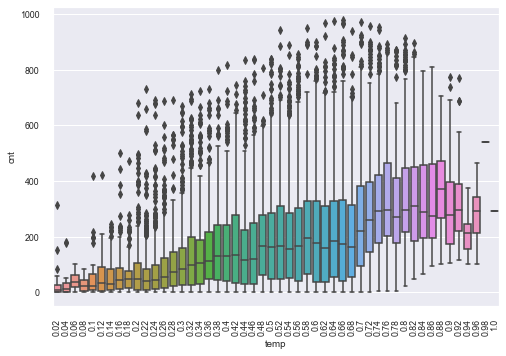

In [205]:
#plots
ax = sns.boxplot(data=df,y="cnt",x="temp",orient="v")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

- higher the temperature more the ride shares

#### FEATURE ATEMP
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)

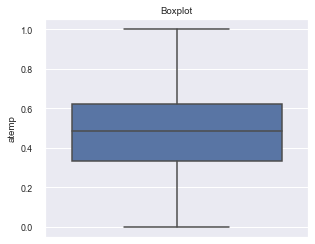

In [206]:
 # boxplot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 3)
sns.boxplot(y=df['atemp'])
plt.title('Boxplot')
plt.show()

[Text(0, 0, '0.0'),
 Text(1, 0, '0.0152'),
 Text(2, 0, '0.0303'),
 Text(3, 0, '0.0455'),
 Text(4, 0, '0.0606'),
 Text(5, 0, '0.0758'),
 Text(6, 0, '0.0909'),
 Text(7, 0, '0.1061'),
 Text(8, 0, '0.1212'),
 Text(9, 0, '0.1364'),
 Text(10, 0, '0.1515'),
 Text(11, 0, '0.1667'),
 Text(12, 0, '0.1818'),
 Text(13, 0, '0.197'),
 Text(14, 0, '0.2121'),
 Text(15, 0, '0.2273'),
 Text(16, 0, '0.2424'),
 Text(17, 0, '0.2576'),
 Text(18, 0, '0.2727'),
 Text(19, 0, '0.2879'),
 Text(20, 0, '0.303'),
 Text(21, 0, '0.3182'),
 Text(22, 0, '0.3333'),
 Text(23, 0, '0.3485'),
 Text(24, 0, '0.3636'),
 Text(25, 0, '0.3788'),
 Text(26, 0, '0.3939'),
 Text(27, 0, '0.4091'),
 Text(28, 0, '0.4242'),
 Text(29, 0, '0.4394'),
 Text(30, 0, '0.4545'),
 Text(31, 0, '0.4697'),
 Text(32, 0, '0.4848'),
 Text(33, 0, '0.5'),
 Text(34, 0, '0.5152'),
 Text(35, 0, '0.5303'),
 Text(36, 0, '0.5455'),
 Text(37, 0, '0.5606'),
 Text(38, 0, '0.5758'),
 Text(39, 0, '0.5909'),
 Text(40, 0, '0.6061'),
 Text(41, 0, '0.6212'),
 Text(42, 

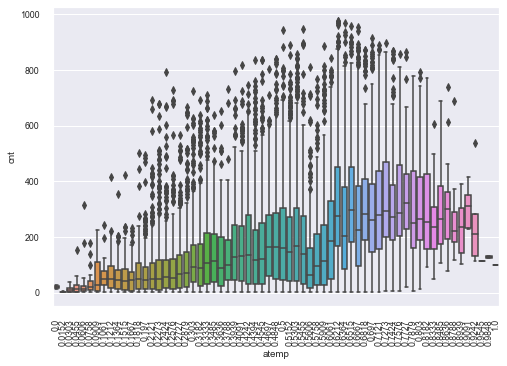

In [207]:

ax = sns.boxplot(data=df,y="cnt",x="atemp",orient="v")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

- it shows similar values as temp and and nothing more
- we should get rid of this column

In [208]:
df = df.drop('atemp',axis = 1)

#### FEATURE HUMIDITY 

-  hum: Normalized humidity. The values are divided to 100 (max)


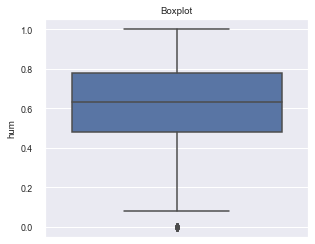

In [209]:
 # boxplot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 3)
sns.boxplot(y=df['hum'])
plt.title('Boxplot')
plt.show()

[Text(0, 0, '0.0'),
 Text(1, 0, '0.08'),
 Text(2, 0, '0.1'),
 Text(3, 0, '0.12'),
 Text(4, 0, '0.13'),
 Text(5, 0, '0.14'),
 Text(6, 0, '0.15'),
 Text(7, 0, '0.16'),
 Text(8, 0, '0.17'),
 Text(9, 0, '0.18'),
 Text(10, 0, '0.19'),
 Text(11, 0, '0.2'),
 Text(12, 0, '0.21'),
 Text(13, 0, '0.22'),
 Text(14, 0, '0.23'),
 Text(15, 0, '0.24'),
 Text(16, 0, '0.25'),
 Text(17, 0, '0.26'),
 Text(18, 0, '0.27'),
 Text(19, 0, '0.28'),
 Text(20, 0, '0.29'),
 Text(21, 0, '0.3'),
 Text(22, 0, '0.31'),
 Text(23, 0, '0.32'),
 Text(24, 0, '0.33'),
 Text(25, 0, '0.34'),
 Text(26, 0, '0.35'),
 Text(27, 0, '0.36'),
 Text(28, 0, '0.37'),
 Text(29, 0, '0.38'),
 Text(30, 0, '0.39'),
 Text(31, 0, '0.4'),
 Text(32, 0, '0.41'),
 Text(33, 0, '0.42'),
 Text(34, 0, '0.43'),
 Text(35, 0, '0.44'),
 Text(36, 0, '0.45'),
 Text(37, 0, '0.46'),
 Text(38, 0, '0.47'),
 Text(39, 0, '0.48'),
 Text(40, 0, '0.49'),
 Text(41, 0, '0.5'),
 Text(42, 0, '0.51'),
 Text(43, 0, '0.52'),
 Text(44, 0, '0.53'),
 Text(45, 0, '0.54'),
 Tex

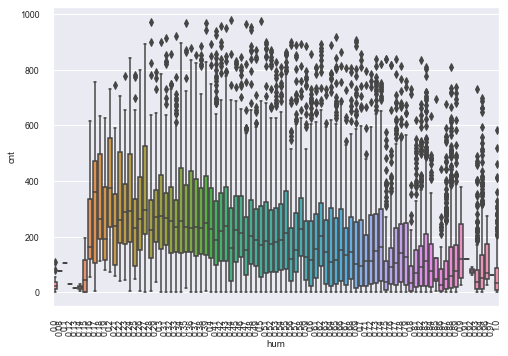

In [210]:

ax = sns.boxplot(data=df,y="cnt",x="hum",orient="v")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

- bike ride shares are higher when humidity is higher 

#### FEATURE WINDSPEED
- windspeed: Normalized wind speed. The values are divided to 67 (max)

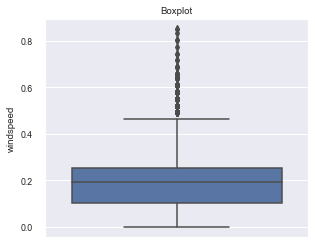

In [211]:
 # boxplot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 3)
sns.boxplot(y=df['windspeed'])
plt.title('Boxplot')
plt.show()

[Text(0, 0, '0.0'),
 Text(1, 0, '0.0896'),
 Text(2, 0, '0.1045'),
 Text(3, 0, '0.1343'),
 Text(4, 0, '0.1642'),
 Text(5, 0, '0.194'),
 Text(6, 0, '0.2239'),
 Text(7, 0, '0.2537'),
 Text(8, 0, '0.2836'),
 Text(9, 0, '0.2985'),
 Text(10, 0, '0.3284'),
 Text(11, 0, '0.3582'),
 Text(12, 0, '0.3881'),
 Text(13, 0, '0.4179'),
 Text(14, 0, '0.4478'),
 Text(15, 0, '0.4627'),
 Text(16, 0, '0.4925'),
 Text(17, 0, '0.5224'),
 Text(18, 0, '0.5522'),
 Text(19, 0, '0.5821'),
 Text(20, 0, '0.6119'),
 Text(21, 0, '0.6418'),
 Text(22, 0, '0.6567'),
 Text(23, 0, '0.6866'),
 Text(24, 0, '0.7164'),
 Text(25, 0, '0.7463'),
 Text(26, 0, '0.7761'),
 Text(27, 0, '0.806'),
 Text(28, 0, '0.8358'),
 Text(29, 0, '0.8507')]

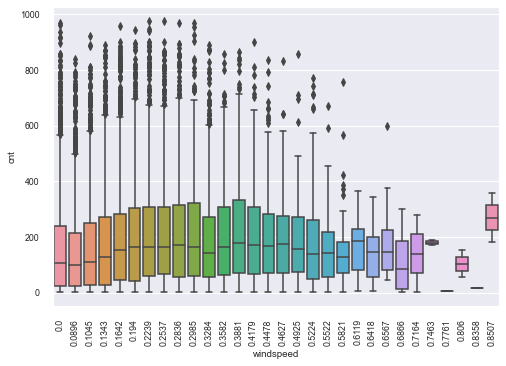

In [212]:

ax = sns.boxplot(data=df,y="cnt",x="windspeed",orient="v")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

- Bike rental demand is variable in windspeed 

#### FEATURE CASAUL
- casual: count of casual users

In [213]:
df.casual.describe()

count    17379.000000
mean        35.676218
std         49.305030
min          0.000000
25%          4.000000
50%         17.000000
75%         48.000000
max        367.000000
Name: casual, dtype: float64

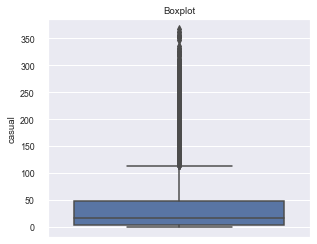

In [214]:
 # boxplot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 3)
sns.boxplot(y=df['casual'])
plt.title('Boxplot')
plt.show()

- casual rentals are very less 
- removing it 

In [215]:
df = df.drop('casual',axis= 1)

#### FEATURE REGISTERED
- registered: count of registered users

In [216]:
df['registered'].describe()

count    17379.000000
mean       153.786869
std        151.357286
min          0.000000
25%         34.000000
50%        115.000000
75%        220.000000
max        886.000000
Name: registered, dtype: float64

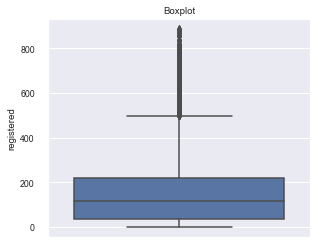

In [217]:
 # boxplot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 3)
sns.boxplot(y=df['registered'])
plt.title('Boxplot')
plt.show()

- these are the registered users and do not have much influence on predicting number of rides 
- removing it

In [218]:
df = df.drop('registered',axis = 1)

In [219]:
df.head()

,dteday,season,yr,mnth,hr,holiday,workingday,weathersit,temp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,0,1,0.24,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,0,1,0.22,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,0,1,0.22,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,0,1,0.24,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,0,1,0.24,0.75,0.0,1


#### TRAIN TEST SPLIT 

- 80% data as training data and 20% as test data

In [220]:
y = df['cnt']
x = df.drop('cnt',axis = 1)

In [221]:

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=43)

In [222]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((13903, 11), (3476, 11), (13903,), (3476,))

#### OUTLIER CHECK FOR FEATURE weathersit and hum

In [223]:
price_upper_limit, price_lower_limit = find_skewed_boundaries(X_train, 'weathersit', 3.0)
price_upper_limit, price_lower_limit

(5.0, -2.0)

In [224]:
# Now let's replace the outliers by the maximum and minimum limit

X_train['weathersit']= np.where(X_train['weathersit'] > price_upper_limit, price_upper_limit,
                      np.where(X_train['weathersit'] < price_lower_limit, price_lower_limit,X_train['weathersit']))

In [225]:
X_train.shape

(13903, 11)

In [226]:

X_test['weathersit']= np.where(X_test['weathersit'] > price_upper_limit, price_upper_limit,
                      np.where(X_test['weathersit'] < price_lower_limit, price_lower_limit,X_test['weathersit']))

In [227]:
X_test.shape

(3476, 11)

In [228]:
price_upper_limit, price_lower_limit = find_skewed_boundaries(X_train, 'hum', 3.0)
price_upper_limit, price_lower_limit

(1.7100000000000002, -0.4600000000000002)

In [229]:


X_train['hum']= np.where(X_train['hum']> price_upper_limit, price_upper_limit,
                      np.where(X_train['hum']< price_lower_limit, price_lower_limit,X_train['hum']))

In [230]:
X_train.shape

(13903, 11)

In [231]:

X_test['hum']= np.where(X_test['hum']> price_upper_limit, price_upper_limit,
                      np.where(X_test['hum']< price_lower_limit, price_lower_limit,X_test['hum']))

In [232]:
X_test.shape

(3476, 11)

- outlier check passed

#### FEATURE SCALING 

In [233]:
X_train.head()

,dteday,season,yr,mnth,hr,holiday,workingday,weathersit,temp,hum,windspeed
1823,2011-03-21,2,0,3,17,0,1,2.0,0.54,0.64,0.2537
13153,2012-07-07,3,1,7,6,0,0,1.0,0.74,0.74,0.1045
191,2011-01-09,1,0,1,6,0,0,1.0,0.10,0.49,0.2836
12518,2012-06-10,2,1,6,19,0,0,1.0,0.82,0.28,0.2836
8199,2011-12-13,4,0,12,7,0,1,1.0,0.16,0.80,0.1642


In [234]:
feats_to_scale_train = X_train[['temp','hum','windspeed']]

In [235]:
feats_to_scale_test = X_test[['temp','hum','windspeed']]

In [236]:
X_train.head()

,dteday,season,yr,mnth,hr,holiday,workingday,weathersit,temp,hum,windspeed
1823,2011-03-21,2,0,3,17,0,1,2.0,0.54,0.64,0.2537
13153,2012-07-07,3,1,7,6,0,0,1.0,0.74,0.74,0.1045
191,2011-01-09,1,0,1,6,0,0,1.0,0.10,0.49,0.2836
12518,2012-06-10,2,1,6,19,0,0,1.0,0.82,0.28,0.2836
8199,2011-12-13,4,0,12,7,0,1,1.0,0.16,0.80,0.1642


In [237]:
X_train = X_train.drop(['dteday','temp','hum','windspeed'], axis=1)

In [238]:
X_test = X_test.drop(['dteday','temp','hum','windspeed'], axis=1)

In this procedure the median is removed from the observations and then they are scaled to the inter-quantile range (IQR). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

X_scaled = X - X_median / ( X.quantile(0.75) - X.quantile(0.25) )

This robust scaling method produces more robust estimates for the center and range of the variable, and is recommended if the data shows outliers.

In a nutshell, RobustScaling:

- centers the median at 0
- variance varies across variables
- may not preserve the shape of the original distribution
- the minimum and maximum values vary.
- robust outliers

In [239]:
# set up the scaler
scaler = RobustScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(feats_to_scale_train)

# transform train and test sets
X_train_scaled = scaler.transform(feats_to_scale_train)
X_test_scaled = scaler.transform(feats_to_scale_test)

In [240]:
# the scaler stores the median values of the features as learned from train set
scaler.center_

array([0.5  , 0.63 , 0.194])

In [241]:
# the scaler stores the IQR values of the features as learned from train set

scaler.scale_

array([0.32  , 0.31  , 0.1492])

In [242]:
# let's transform the returned NumPy arrays to dataframes for the rest of
# the demo

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feats_to_scale_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= feats_to_scale_test.columns)

#### CATEGORICAL ENCODING

In [243]:
X_train.head()

,season,yr,mnth,hr,holiday,workingday,weathersit
1823,2,0,3,17,0,1,2.0
13153,3,1,7,6,0,0,1.0
191,1,0,1,6,0,0,1.0
12518,2,1,6,19,0,0,1.0
8199,4,0,12,7,0,1,1.0


In [244]:
# we create and train the encoder

encoder = OneHotEncoder(categories='auto',
                       sparse=False,
                       handle_unknown='error') # helps deal with rare labels

encoder.fit(X_train[['season','yr','mnth','hr','holiday','workingday','weathersit']])

OneHotEncoder(sparse=False)

In [245]:
# transform the train set

tmp = encoder.transform(X_train[['season','yr','mnth','hr','holiday','workingday','weathersit']])
tmp = pd.DataFrame(tmp)
tmp.columns = encoder.get_feature_names()

pd.DataFrame(tmp).head()

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,x0_1,x0_2,x0_3,x0_4,x1_0,x1_1,x2_1,x2_2,x2_3,x2_4,...,x3_22,x3_23,x4_0,x4_1,x5_0,x5_1,x6_1.0,x6_2.0,x6_3.0,x6_4.0
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [246]:
tmp.shape

(13903, 50)

In [247]:
X_train = X_train.reset_index()

In [248]:
X_train  = pd.concat([X_train, tmp], axis=1)

In [249]:
X_train= X_train.drop(['season','yr','mnth','hr','holiday','workingday','weathersit'],axis=1)

In [250]:
X_train.shape

(13903, 51)

In [251]:
# we can go ahead and transfom the test set
# and then reconstitute it back to a pandas dataframe
# and add the feature names derived by OHE

tmp = encoder.transform(X_test[['season','yr','mnth','hr','holiday','workingday','weathersit']])

tmp = pd.DataFrame(tmp)
tmp.columns = encoder.get_feature_names()

tmp.head()

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,x0_1,x0_2,x0_3,x0_4,x1_0,x1_1,x2_1,x2_2,x2_3,x2_4,...,x3_22,x3_23,x4_0,x4_1,x5_0,x5_1,x6_1.0,x6_2.0,x6_3.0,x6_4.0
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [252]:
X_test = X_test.reset_index()

In [253]:
X_test = pd.concat([X_test, tmp], axis=1)

In [254]:
X_test = X_test .drop(['season','yr','mnth','hr','holiday','workingday','weathersit'],axis=1)

In [255]:
X_test.shape

(3476, 51)

In [256]:
train_data = pd.concat([X_train, X_train_scaled], axis=1)

In [257]:
train_data.shape

(13903, 54)

In [258]:
train_data = train_data.drop('index',axis = 1)

In [259]:
train_data.shape

(13903, 53)

In [260]:
test_data = pd.concat([X_test, X_test_scaled], axis=1)

In [261]:
test_data = test_data.drop('index',axis = 1)

In [262]:
test_data.shape

(3476, 53)

#### FEATURE SELECTION

Constant features are those that show the same value, just one value, for all the observations of the dataset. In other words, the same value for all the rows of the dataset. These features provide no information that allows a machine learning model to discriminate or predict a target.
Identifying and removing constant features is an easy first step towards feature selection and more easily interpretable machine learning models.

To identify constant features, we can use the VarianceThreshold from Scikit-learn. If using the VarianceThreshold, all our variables need to be numerical.

In [263]:
# remove constant features
constant_features = [
    feat for feat in train_data.columns if train_data[feat].std() == 0
]


In [264]:
constant_features

[]

- there are no constant features in the data

Quasi-constant features are those that show the same value for the great majority of the observations of the dataset. In general, these features provide little, if any, information that allows a machine learning model to discriminate or predict a target.

Identifying and removing quasi-constant features, is an easy first step towards feature selection and more interpretable machine learning models.

To identify quasi-constant features, we can use the VarianceThreshold from Scikit-learn

In [265]:

# remove quasi-constant features
sel = VarianceThreshold(
    threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(train_data)  # fit finds the features with low variance

sum(sel.get_support()) # how many not quasi-constant?

52

- only one quasi constant feature to be removed

In [266]:
features_to_keep = train_data.columns[sel.get_support()]

In [267]:
features_to_keep

Index(['x0_1', 'x0_2', 'x0_3', 'x0_4', 'x1_0', 'x1_1', 'x2_1', 'x2_2', 'x2_3',
       'x2_4', 'x2_5', 'x2_6', 'x2_7', 'x2_8', 'x2_9', 'x2_10', 'x2_11',
       'x2_12', 'x3_0', 'x3_1', 'x3_2', 'x3_3', 'x3_4', 'x3_5', 'x3_6', 'x3_7',
       'x3_8', 'x3_9', 'x3_10', 'x3_11', 'x3_12', 'x3_13', 'x3_14', 'x3_15',
       'x3_16', 'x3_17', 'x3_18', 'x3_19', 'x3_20', 'x3_21', 'x3_22', 'x3_23',
       'x4_0', 'x4_1', 'x5_0', 'x5_1', 'x6_1.0', 'x6_2.0', 'x6_3.0', 'temp',
       'hum', 'windspeed'],
      dtype='object')

In [268]:
# we can then remove the features like this
train_data = sel.transform(train_data)
test_data = sel.transform(test_data )

train_data.shape, test_data.shape

((13903, 52), (3476, 52))

In [269]:
# sklearn transformations lead to numpy arrays
# here I transform the arrays back to dataframes
# please be mindful of getting the columns assigned
# correctly


train_data= pd.DataFrame(train_data)
train_data.columns = features_to_keep

test_data= pd.DataFrame(test_data)
test_data.columns = features_to_keep

In [270]:
train_data.shape, test_data.shape

((13903, 52), (3476, 52))

In addition, we may often introduce duplicated features when performing one hot encoding of categorical variables, particularly if our datasets have many and /or highly cardinal categorical variables.
Identifying and removing duplicated, and therefore redundant features, is an easy first step towards feature selection and more interpretable machine learning models.

There is no function in Pandas to find duplicated columns. So we need to write a bit code to do so.
Note Finding duplicated features can be a computationally costly operation in Python, therefore depending on the size of your dataset, you might not always be able to do it.
This method that I describe here to find duplicated features works for both numerical and categorical variables.

In [271]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(train_data.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = train_data.columns[i]

    for col_2 in train_data.columns[i + 1:]:
        if train_data[col_1].equals(train_data[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50


0

- no dupliate features to be removed

Correlation Feature Selection evaluates subsets of features on the basis of the following hypothesis: "Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other".

In [272]:
# find and remove correlated features

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
    
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(train_data, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  4


- there are 4 correlated features which we should remove

In [273]:
corr_features

{'x1_1', 'x4_1', 'x5_1', 'x6_2.0'}

In [274]:
train_data.drop(labels=corr_features, axis=1, inplace=True)
test_data.drop(labels=corr_features, axis=1, inplace=True)

train_data.shape, test_data.shape

((13903, 48), (3476, 48))

#### MODEL TRAINING 

In [275]:
train_data.shape, test_data.shape, y_train.shape,y_test.shape

((13903, 48), (3476, 48), (13903,), (3476,))

#### LINEAR REGRESSION MODEL 

In [276]:


regressor = LinearRegression()
regressor.fit(train_data, y_train)

LinearRegression()

In [277]:
# Predicting the Train set results

Y_pred_train = regressor.predict(train_data)

In [278]:
# Predicting the Test set results

Y_pred_test = regressor.predict(test_data)

In [279]:
# r2 score of train set

r2_linear_train = r2_score(y_train, Y_pred_train)

In [280]:
r2_linear_train

0.6881644534399862

In [281]:
r2_linear_test = r2_score(y_test, Y_pred_test)

In [282]:
r2_linear_test

0.6729479511761802

In [283]:
# different metrics used

MSE  = mean_squared_error(y_test,Y_pred_test)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)



MSE : 10831.723559766973
RMSE : 104.07556658393445


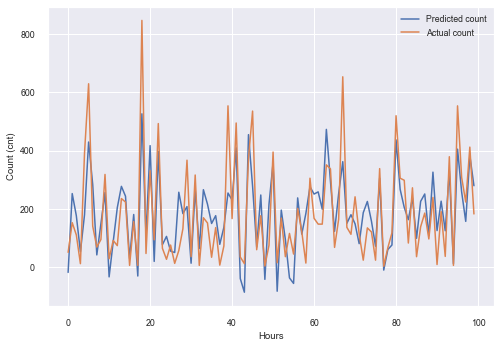

In [284]:
fig,ax = plt.subplots()
plt.plot(Y_pred_test[:100,], label='Predicted count')
plt.plot(np.array(y_test[:100,]), label='Actual count')
ax.set_xlabel('Hours')
ax.set_ylabel('Count (cnt)')
plt.legend();
plt.show()

In [27]:
def get_mean_absolute_deviations(predictions,actual_values):
    """ Compute the mean absolute deviations of predictions vs actual test set values
        
        Arguments:
        * predictions: Our Model's predictions
        * actual_values: Test set output
    
    """
    
    # Convert numpy arrays to data frame as pandas as mean absolute deviation function we want to use
    predictions_dataframe = pd.DataFrame(data = predictions)
    actual_test_set_values_dataframe = pd.DataFrame(data=actual_values)
        
    print("Regression model prediction's Mean Absolute Deviation is ", predictions_dataframe.mad()[0])
    

In [29]:
get_mean_absolute_deviations(Y_pred_test,y_test)

#### LASSO REGRESSION MODEL

In [287]:
### Cross validation ###
lasso = Lasso()
parameters = {'alpha': [0.8,1,10,20,40,80,100,300,700,1000]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(train_data, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.8, 1, 10, 20, 40, 80, 100, 300, 700,
                                   1000]},
             scoring='neg_mean_squared_error')

In [288]:
# getting best parameters
lasso_regressor.best_params_

{'alpha': 0.8}

In [289]:
lasso_regressor.best_score_

-10795.68357341365

In [290]:
Y_pred_lasso = lasso_regressor.predict(test_data)

In [291]:
MSE  = mean_squared_error(y_test,Y_pred_lasso)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 11305.862996114025
RMSE : 106.32903176514881


In [292]:
r2_lasso_test = r2_score(y_test,Y_pred_lasso)

In [293]:
r2_lasso_test

0.658631829348491

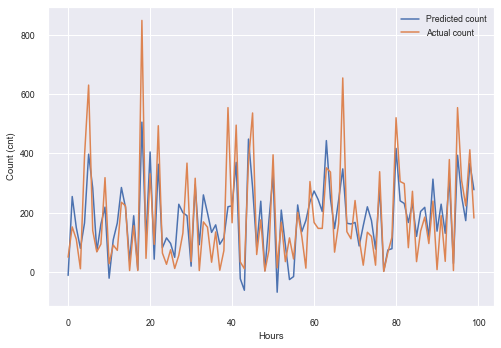

In [294]:
fig,ax = plt.subplots()
plt.plot(Y_pred_lasso[:100,], label='Predicted count')
plt.plot(np.array(y_test[:100,]), label='Actual count')
ax.set_xlabel('Hours')
ax.set_ylabel('Count (cnt)')
plt.legend();
plt.show()

In [295]:
get_mean_absolute_deviations(Y_pred_lasso ,y_test)

Linear Regression model prediction's Mean Absolute Deviation is  113.1769127548671
Test set's Mean Absolute Deviation is 143.6028044019752


#### RIDGE REGRESSION MODEL

In [296]:

ridge = Ridge()
parameters = {'alpha': [1,0.001,10,20,35,60,70,100,800,1200]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_regressor.fit(train_data,y_train)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': [1, 0.001, 10, 20, 35, 60, 70, 100, 800,
                                   1200]},
             scoring='neg_mean_squared_error')

In [297]:
ridge_regressor.best_params_

{'alpha': 1}

In [298]:
ridge_regressor.best_score_

-10375.430353844684

In [299]:
Y_pred_ridge = ridge_regressor.predict(test_data)

In [300]:
# evaluating metrics

MSE  = mean_squared_error(y_test,Y_pred_ridge)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 10829.51666172337
RMSE : 104.06496366079878


In [301]:
r2_ridge_test = r2_score(y_test,Y_pred_ridge)

In [302]:
r2_ridge_test

0.6730145860494505

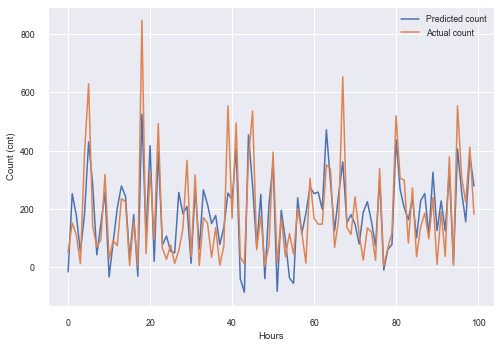

In [303]:
fig,ax = plt.subplots()
plt.plot(Y_pred_ridge[:100,], label='Predicted count')
plt.plot(np.array(y_test[:100,]), label='Actual count')
ax.set_xlabel('Hours')
ax.set_ylabel('Count (cnt)')
plt.legend();
plt.show()

In [304]:
get_mean_absolute_deviations(Y_pred_ridge ,y_test)

Linear Regression model prediction's Mean Absolute Deviation is  125.65366503358254
Test set's Mean Absolute Deviation is 143.6028044019752


#### DECISION TREE REGRESSOR

In [305]:
# training model



param = {'max_depth' : [1,4,5,6,7,10,15,20,8]}

gridSearch_decisionTree=GridSearchCV(DecisionTreeRegressor(),param,scoring='r2',cv=6)
gridSearch_decisionTree.fit(train_data,y_train)




GridSearchCV(cv=6, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 4, 5, 6, 7, 10, 15, 20, 8]},
             scoring='r2')

In [306]:
gridSearch_decisionTree.best_estimator_

DecisionTreeRegressor(max_depth=20)

In [307]:
tree = DecisionTreeRegressor(max_depth= 20)

In [308]:
tree.fit(train_data, y_train)

DecisionTreeRegressor(max_depth=20)

In [309]:
Y_pred_dtree_reg = tree.predict(test_data)

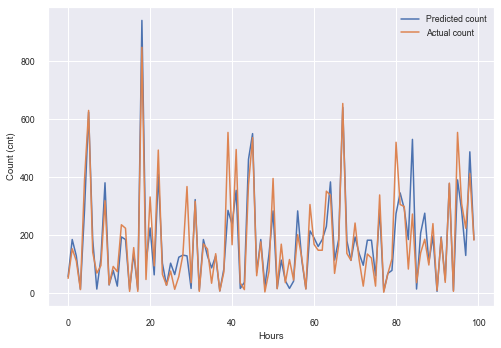

In [310]:
fig,ax = plt.subplots()
plt.plot(Y_pred_dtree_reg[:100,], label='Predicted count')
plt.plot(np.array(y_test[:100,]), label='Actual count')
ax.set_xlabel('Hours')
ax.set_ylabel('Count (cnt)')
plt.legend();
plt.show()

In [311]:
get_mean_absolute_deviations(Y_pred_dtree_reg ,y_test)



Linear Regression model prediction's Mean Absolute Deviation is  137.18443074539624
Test set's Mean Absolute Deviation is 143.6028044019752


In [312]:
r2_dtree_reg_test = r2_score(y_test,Y_pred_dtree_reg)

In [313]:
r2_dtree_reg_test 

0.8497951927778425

#### RANDOM FOREST REGRESSOR 

In [314]:
# training model


randomForestAlgo = RandomForestRegressor()


param = {'n_estimators' : [int(x) for x in np.linspace(start=10,stop=20, num=5)], 
         'max_depth' : [10,15,20],
         'min_samples_split':[2,4],
         'min_samples_leaf':[1,2],
         'bootstrap' : [True,False]
        }

gridSearch_RandomForest=GridSearchCV(randomForestAlgo,param,scoring='r2',cv=5)
gridSearch_RandomForest.fit(train_data,y_train)



GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [10, 12, 15, 17, 20]},
             scoring='r2')

In [315]:
gridSearch_RandomForest.best_estimator_

RandomForestRegressor(max_depth=20, min_samples_split=4, n_estimators=20)

In [316]:
rtree = RandomForestRegressor(max_depth= 20, 
                            min_samples_split= 4,
                            n_estimators= 20
                        )

In [317]:
rtree.fit(train_data, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=4, n_estimators=20)

In [318]:
Y_pred_rtree_reg = rtree.predict(test_data)

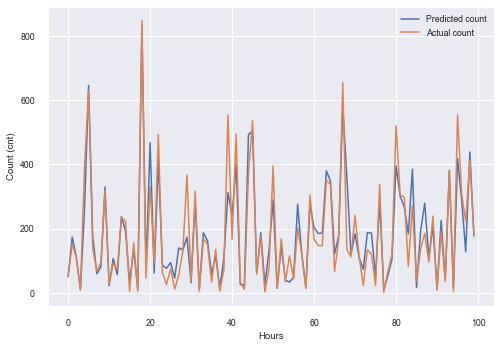

In [319]:
fig,ax = plt.subplots()
plt.plot(Y_pred_rtree_reg[:100,], label='Predicted count')
plt.plot(np.array(y_test[:100,]), label='Actual count')
ax.set_xlabel('Hours')
ax.set_ylabel('Count (cnt)')
plt.legend();
plt.show()

In [320]:
get_mean_absolute_deviations(Y_pred_rtree_reg ,y_test)

Linear Regression model prediction's Mean Absolute Deviation is  131.5694469049291
Test set's Mean Absolute Deviation is 143.6028044019752


In [321]:


r2_random_forest_reg_test = r2_score(y_test,Y_pred_rtree_reg)

In [322]:
r2_random_forest_reg_test 



0.9064552067847962

#### XG BOOST 

In [323]:
from xgboost import XGBRegressor

In [324]:
# Various hyper-parameters to tune
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objectvie':'reg:squarederror',
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500],
              'cv':[2,5],
              'n_jobs':[2,5]}



In [325]:
gridSearch_XG_Boost=GridSearchCV(xgb1,param,scoring='r2',cv=5)



In [326]:
gridSearch_XG_Boost.fit(train_data,y_train)

[19:27:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "bootstrap", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:27:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "bootstrap", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:27:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "bootstrap", "min_samples_leaf", "min_sample

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n..._jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                      

In [327]:
gridSearch_XG_Boost.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=True,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=20, min_child_weight=1,
             min_samples_leaf=1, min_samples_split=2, missing=nan,
             monotone_constraints='()', n_estimators=17, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, ...)

In [328]:
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
import xgboost as xgb

X = train_data # Feature matrix in pd.DataFrame format
y = y_train # Target vector in pd.Series format



# Instantiate an XGBoost object with hyperparameters
xgb_reg = xgb.XGBRegressor(max_depth=20, n_estimators=17, n_jobs=8,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05)

# Train the model with train data sets
xgb_reg.fit(train_data, y_train)

y_pred_xgboost = xgb_reg.predict(test_data) # Predictions

r2_xgb_regressor = r2_score(y_test, y_pred_xgboost)

print("\nRMSE: ", np.round(RMSE, 2))
print()
print("R-Squared: ", np.round(r2_xgb_regressor , 2))

[19:33:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



RMSE:  104.06

R-Squared:  0.53


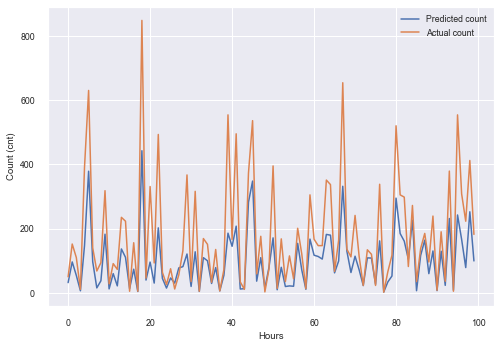

In [329]:
fig,ax = plt.subplots()
plt.plot(y_pred_xgboost[:100,], label='Predicted count')
plt.plot(np.array(y_test[:100,]), label='Actual count')
ax.set_xlabel('Hours')
ax.set_ylabel('Count (cnt)')
plt.legend();
plt.show()

In [330]:
get_mean_absolute_deviations(y_pred_xgboost ,y_test)

Linear Regression model prediction's Mean Absolute Deviation is  76.16792
Test set's Mean Absolute Deviation is 143.6028044019752


In [331]:
model_list = ['Linear regression','Lasso regression','Ridge regression','Decision Tree Regressor','Random Forest Regressor','Xgboost Regression']
result_list = [r2_linear_test,r2_lasso_test,r2_ridge_test,r2_dtree_reg_test, r2_random_forest_reg_test ,r2_xgb_regressor]
results_df = pd.DataFrame()

results_df['model name'] = model_list
results_df['R2-score'] = result_list


In [332]:
results_df

,model name,R2-score
0,Linear regression,0.672948
1,Lasso regression,0.658632
2,Ridge regression,0.673015
3,Decision Tree Regressor,0.849795
4,Random Forest Regressor,0.906455
5,Xgboost Regression,0.529589


### BEST PERFORMING MODEL IS RANDOM FOREST REGRESSOR 